<a href="https://colab.research.google.com/github/prithwis/parashar21/blob/main/P21_45_06_V2_SingleChart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://1.bp.blogspot.com/_5QlanosqxiQ/SXLOLTu7S7I/AAAAAAAAAm8/0r6C7lCxsic/S1600-R/p21-header-003.png) <br>


---



[Prithwis Mukerjee](http://www.yantrajaal.com) ||
Website - [Parashar21](https://parashar21.blogspot.com)<br>

Copyright (c) 2022, Prithwis Mukerjee All rights reserved.

This source code is licensed under the GNU GPL v3.0 -style license found in the LICENSE file in the root directory of this source tree.

#Rationale

Why MongoDB here? <br> <br>

The core 'engine' of Parashar21 is designed to cast horoscopes using the [Python](https://pypi.org/project/pyswisseph/) version of the [Swiss Ephemeris](https://www.astro.com/swisseph/) software, convert the data to JSON format and then store the same in a MongoDB database.<br> The Mongo query language was next used to filter out horoscopes that met certain criteria and then create human readable MS-Word documents for each selected horoscope. <br> <br>
For full information about this project, please see the [Parashar21](https://prithwis.github.io/parashar21/) github page.


#SetUp Environment

##Install Software

In [1]:
from datetime import datetime
import pytz
#print('Tested on ',datetime.now(pytz.timezone('Asia/Calcutta')))

#!python --version
#!lsb_release -a

#check which version of MongoDB  is available
#!apt-cache policy mongodb

#check which versions of software are available
#!pip3 index versions pymongo
#!pip3 index versions pyswisseph
#!pip3 index versions python-docx


In [2]:
!pip -qq install pyswisseph                                 # https://stackoverflow.com/questions/64277506/pip-install-options-unclear
!pip -qq install python-docx                                # https://python-docx.readthedocs.io/en/latest/
#!/usr/bin/python3 -m pip install "pymongo[srv]"            # Required only if used with Atlas remote servers
!pip -qq install pymongo                                    # Required for Mongo client
!apt install mongodb > /dev/null                            # install local MongoDB server           
!service mongodb start                                      # start Local MongoDB server instance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 42.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.9/492.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 24.6 MB/s eta 0:00:00


 * Starting database mongodb
   ...done.


##Install, import prerequisites

In [3]:
#Utility functions 
from pymongo import MongoClient
import pandas as pd
import dateutil
import json
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from datetime import datetime
from datetime import timedelta
import pytz
from google.colab import files

#import matplotlib.pyplot as plt
#import math


In [4]:
#Load p21 modules from github
!wget -O p21.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21.py                  # all global variables
!wget -O p21utils.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utils.py        # large number of utility functions
!wget -O p21utilsR.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utilsR.py      # report writing utility functions
!wget -O p21swe.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21swe.py            # Swiss Ephemeris functions
!wget -O p21YogInfo.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21YogInfo.py    # yog data - description and conditions 
# ---------------------------

#!wget -O Saraswati.png -q https://github.com/prithwis/parashar21/raw/main/images/Saraswati02.png                 
#!wget -O p21logo.png -q https://github.com/prithwis/parashar21/raw/main/images/p21logo-002-1.png   



In [5]:
import p21
import p21utils
import p21utilsR
import p21swe
import p21YogInfo
# ------------------------------------------------
# required for multiple imports of the same module
# ------------------------------------------------
import importlib
importlib.reload(p21)
importlib.reload(p21utils)
importlib.reload(p21utilsR)
importlib.reload(p21swe)
importlib.reload(p21YogInfo)

10 Yogs on record
0 : Amala Yog | 10th from Moon OR Lagna should have a benefic
1 : RajLakshana Yog | Jupiter, Venus, Mercury, Moon should be in Lagna or they should be in a Kendra
2 : Chatussagara Yog | All the Kendras 1/4/7/10 are occupied by planets, Ra, Ke not counted here
3 : Adhi678 Yog | Benefics located in 6/7/8th  from Moon
4 : Chandra Mangal Yog | Mars Conjoins Moon or  Mars and Moon in Mutual Aspect
5 : Kemadruma Yog : No planets on either sides of the Moon
6 : Anapha Yog |Planets other than Sun in 12th Place from Moon
7 : Sunapha Yog |Planets other than Sun in 2nd Place from Moon
8 : Dhurdhura Yog | Planets on both sides of the Moon
9 : Gajakesari Yog | Jupiter is in Kendra or 1,4,7,10th from Moon
10 Yogs on record
0 : Amala Yog | 10th from Moon OR Lagna should have a benefic
1 : RajLakshana Yog | Jupiter, Venus, Mercury, Moon should be in Lagna or they should be in a Kendra
2 : Chatussagara Yog | All the Kendras 1/4/7/10 are occupied by planets, Ra, Ke not counted here
3 :

<module 'p21YogInfo' from '/content/p21YogInfo.py'>

In [6]:
#Download Swiss Ephemeris Files 
!wget -q http://www.astro.com/ftp/swisseph/ephe/seas_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/semo_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/sepl_18.se1
!mkdir ephe
!mv *.se1 ephe
#------------------------------
# Configure SWE with appropriate parameters
#
p21swe.C01_configSWE()

##Local Mongo

We use a locally installed, temporary MongoDB to store and process the data


In [7]:
# Connect to local MongoDB

mongoURI = "mongodb://localhost:27017/"                               # for local server
client = MongoClient(mongoURI)
db = client.parashar21

#Report Generation Function

In [8]:
def genChart(ChartStyle):
      
    chartData = chart.iloc[0]
    RepID = chart.iloc[0]['pid']['name']+'_'+p21.AnalysisType[0:3]+'_'+ChartStyle[0:1]
    now = datetime.now(pytz.timezone('Asia/Kolkata'))
    fileName = 'p21_'+RepID+'_'+now.strftime("%H%M%S")+'.doc'

    #print(chartData)
    # ---------------------------------------------------------
    p21utilsR.R01_CreateReportDoc(None,None,'SingleChart')        # Creates MS Word Doc called p21.document for Single or MULTIPLE charts
    #p21utilsR.R01A_CreateReportDoc(RepID)                           # Creates MS Word Doc called p21.document for SINGLE chart
    # ----------------------------------------------------------
    
    p21utilsR.R511_parseChartData(chartData)                # Break up database data into useful pieces
                                                            # Creates two primary dicts, GLon, GRet
    p21utilsR.R30_LocateYogs()
    
    #print(p21.beneficG)
    for ctype in ['Rashi','Navamsa']:
        p21.ChartType = ctype
        p21utils.R11_LocateGrahaInRashi()   # Converts Graha Long to Rashi positions
                                            # Rashi Num as well as Rashi name
        if ChartStyle == 'Bengal':
            p21utilsR.R12B_drawChart_Bengal()    # Draw Chart in Bengal style
        if ChartStyle == 'South':
            p21utilsR.R12B_drawChart_South()    # Draw Chart in South style
        if ChartStyle == 'North':
            p21utilsR.R12B_drawChart_North()    # Draw Chart in North style
        
    
    p21utilsR.R512_FormatPage('SingleChart')                  # this is where the details of the chart are printed out
    
    # ------------------------------------
    p21.document.save(fileName)
    return fileName
    
print("Executed at ", datetime.now(pytz.timezone('Asia/Kolkata')))

Executed at  2023-05-08 07:58:50.665721+05:30


# Store and Retrieve

In [9]:
def StoreRetrieveChart():
    with open('peopleData.json') as json_file:
        oneChart = json.load(json_file)

    db.drop_collection('khona21')
    db.create_collection('khona21')               # Optional collection creation 
    p21.kollection = db.khona21                   # Set the collection to work with

    # Insert the single chart

    insert_result = p21.kollection.insert_one(oneChart)
    insert_result.acknowledged  
    chart = pd.DataFrame(list(p21.kollection.find({},p21.selCols)))
    return(chart)

print("Executed at ", datetime.now(pytz.timezone('Asia/Kolkata')))

Executed at  2023-05-08 08:01:39.767110+05:30


# Natal Chart
Data for others can be added by adding an extra line in the cell below. Please follow the same pattern as in the other lines


## Natal Data

In [ ]:
# Sample Data for some people
#
#%%writefile peopleData.csv
#Gender,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name,tag1,tag2,tag3,tag4,tag5,tag6
#M,17,9,1950,23:11,5.5,23.72,63.36,IST,standard,NDModi,Politician,nil,Administrator,nil,nil,nil
#F,10,10,1954,11:00,5.5,13.08,80.27,IST,standard,Rekha,Actor,nil,Dancer,nil,nil,nil
#M,15,10,1931,1:15,5.5,9.29,79.31,IST,standard,APJAbdulKalam,Engineer,nil,PublicFigure,nil,nil,nil
#F,19,11,1917,23:11,5.5,25.43,81.85,IST,standard,IndiraG,Politician,nil,PublicFigure,nil,nil,nil
#M,15,10,1961,23:42,5.5,22.57,88.37,IST,standard,Person1,Engineer,nil,Teacher,nil,PostGraduate,nil
#F,19,12,1965,10:26,5.5,22.57,88.37,IST,standard,Person1,Author,nil,Homemaker,nil,PostGraduate,nil
#M,9,10,1990,23:09,5.5,22.57,88.37,IST,standard,Person1,Engineer,nil,Teacher,nil,PostGraduate,nil
#F,12,9,1990,0:52,5.5,22.87,88.37,IST,standard,Person1,Biologist,nil,Scientist,nil,PostGraduate,nil

#Read Birth Data from a file
#!wget -O peopleData.csv -q https://raw.githubusercontent.com/prithwis/parashar21/main/data/Test5Data.txt # 5 Person Test Data
#!cat peopleData.csv

In [ ]:
# Get Lat Long for Place of Birth here
import requests
import urllib.parse

address = 'Vadnagar, Gujarat, India'
url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

response = requests.get(url).json()
print(response[0]["lat"])
print(response[0]["lon"])
#print(response)

23.7853622
72.6332132


## Natal Data Preparation

In [10]:
%%writefile peopleData.csv
Gender,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name,tag1,tag2,tag3,tag4,tag5,tag6
M,15,10,1961,23:42,5.5,22.57,88.37,IST,standard,Person1,Engineer,nil,Teacher,nil,PostGraduate,nil

Writing peopleData.csv


In [11]:
# Load CSV data into Pandas dataframe
#
df = pd.read_csv('peopleData.csv')
df.head()

,Gender,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name,tag1,tag2,tag3,tag4,tag5,tag6
0,M,15,10,1961,23:42,5.5,22.57,88.37,IST,standard,Person1,Engineer,nil,Teacher,nil,PostGraduate,nil


In [12]:
#%%time

p21.AnalysisType = 'Rashi'                                     # one of ['Rashi','Navamsa']
#p21.AnalysisType = 'Navamsa'                                    # one of ['Rashi','Navamsa']
p21.ChartType = p21.AnalysisType

p21.Gochar = False                                              # This should be set to False, in all cases
# ------------------------------------------------------------
# Converts date/time info into a detailed horoscope chart 
# Stores the same in a JSON file, to be inserted into a local MongoDB database
# 
p21swe.C61_Cast2JSON(df)
print(p21.GLon['La'],p21.GLon['Mo'])


1 records processed, so far
1  records generated and stored in file peopleData.json
98.204 250.52


##Store and Retrieve Natal Chart

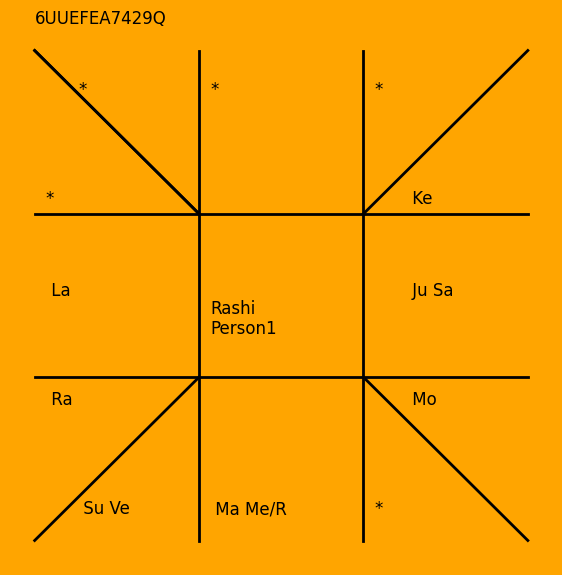

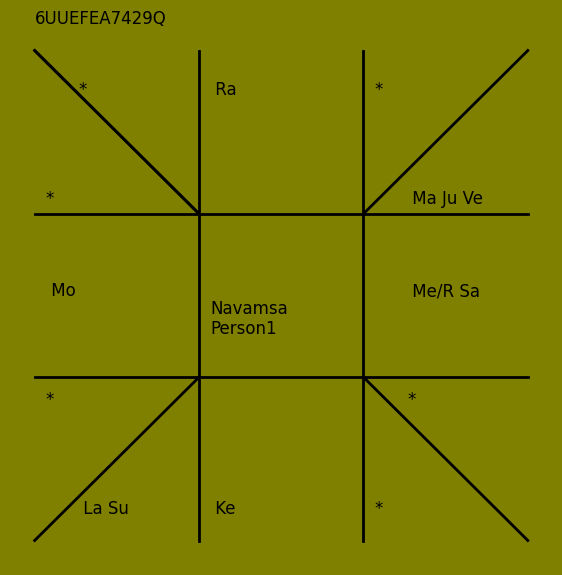

In [13]:
chart = StoreRetrieveChart()
ReportFile = genChart('Bengal')

#Gochar Chart

In [14]:
# This cell to be executed ONLY for creating Gochar charts 
# And ONLY after natal chart has been created, otherwise errors
# othwerwise skip
#
!sed -n 1p peopleData.csv > peopleData2.csv
#p21.gName2 = 'GC'+p21.chart['pid']['name']
p21.SubMoonLong = p21.chart['GLon']['Mo']
print(p21.gName, p21.SubMoonLong)
p21.Gochar = True 

if p21.Gochar :
    now = datetime.now(pytz.timezone('Asia/Kolkata'))
    timeTxt = now.strftime("%-d,%-m,%Y,%-H:%-M")
    GocharTxt = 'x,'+timeTxt+',5.5,25.43,81.85,IST,standard,'+p21.gName+',nil,nil,nil,nil,nil,nil'                  # Using Lat, Long of Calcutta for Gochar
    print(GocharTxt)
    with open("peopleData2.csv", 'a') as file1:
        file1.write(GocharTxt)
    

_Gochar 250.52
x,8,5,2023,8:3,5.5,25.43,81.85,IST,standard,_Gochar,nil,nil,nil,nil,nil,nil


In [15]:
# Load CSV data into Pandas dataframe
#
df = pd.read_csv('peopleData2.csv')
df.head()


,Gender,DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,TZ_Name,TZ_Type,Name,tag1,tag2,tag3,tag4,tag5,tag6
0,x,8,5,2023,8:3,5.5,25.43,81.85,IST,standard,_Gochar,nil,nil,nil,nil,nil,nil


In [16]:
p21.AnalysisType = 'Rashi'                                     # one of ['Rashi','Navamsa']
#p21.AnalysisType = 'Navamsa'                                    # one of ['Rashi','Navamsa']
p21.ChartType = p21.AnalysisType

p21swe.C61_Cast2JSON(df)
print(p21.GLon['La'],p21.GLon['Mo'])

La long reset to  250.52
1 records processed, so far
1  records generated and stored in file peopleData.json
250.52 233.478


##Store and Retrieve Gochar Chart

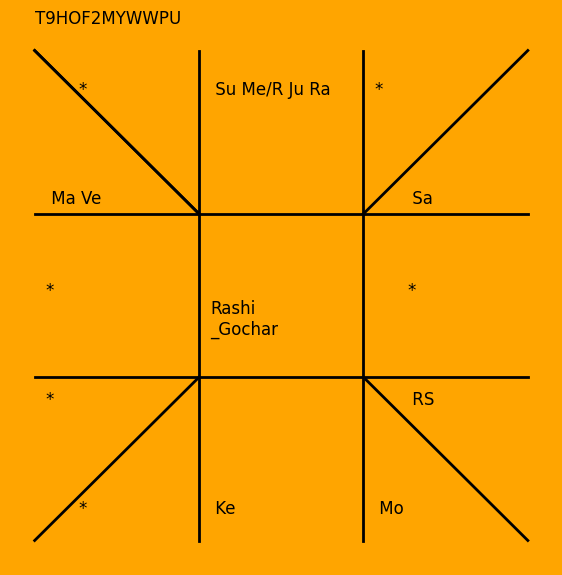

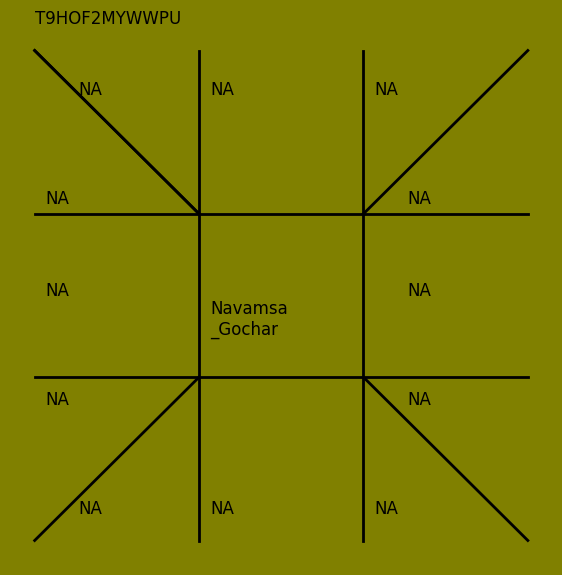

In [17]:
chart = StoreRetrieveChart()
ReportFile = genChart('Bengal')

In [ ]:
#!cat peopleData.json

#Retrieve Charts 
Reports will be available as DOC files in the VM drive <br>
Please specify style of report, 'Bengal', 'North' or 'South' while calling the report generation routine <br>


## Retrieve, Display and Analyse the SingleChart chart

In [ ]:
#
#Get List of Persons whose charts are found in the database
#
selCond = {}                                              # All Charts
#pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))
#pd.DataFrame(list(p21.kollection.find(selCond,{'pid.name':1,'_id':0})))
pd.DataFrame(list(p21.kollection.find(selCond,{'pid.name':1})))
#pd.DataFrame(list(p21.kollection.find(selCond,p21.selCols)))


,_id,pid
0,645797a4004d072716dd4d8c,{'name': '_Gochar'}


In [ ]:
#
# Download last Report File
#
files.download(ReportFile)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm *.doc

#Chronobooks <br>
![alt text](https://1.bp.blogspot.com/-lTiYBkU2qbU/X1er__fvnkI/AAAAAAAAjtE/GhDR3OEGJr4NG43fZPodrQD5kbxtnKebgCLcBGAsYHQ/s600/Footer2020-600x200.png)<hr>
Chronotantra and Chronoyantra are two science fiction novels that explore the collapse of human civilisation on Earth and then its rebirth and reincarnation both on Earth as well as on the distant worlds of Mars, Titan and Enceladus. But is it the human civilisation that is being reborn? Or is it some other sentience that is revealing itself. 
If you have an interest in AI and found this material useful, you may consider buying these novels, in paperback or kindle, from [http://bit.ly/chronobooks](http://bit.ly/chronobooks)